In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import numpy as np

import pandas as pd
import cudf as gd

from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

In [5]:
DATASET_ID = 'european_starling_gentner_segmented'

In [6]:
indv = 'b1060'
window_length_ms = 200
hop_length_ms = 20
window_length_frames = int(window_length_ms / hop_length_ms)
window_length_frames

10

### load data

In [7]:
keys_loc = DATA_DIR /'umap_windows' / DATASET_ID / ('keya_starling_' + indv + '_' + str(window_length_ms) +'.npy')
keys  = np.load(keys_loc.as_posix())
keys[:3]

array(['2017-12-08_16-45-25-480000', '2017-11-12_18-41-45-580000',
       '2017-11-14_19-34-31-540000'], dtype='<U26')

In [8]:
window_length_loc = DATA_DIR /'umap_windows' / DATASET_ID / ('window_lengths_starling_' + indv + '_' + str(window_length_ms) +'.npy')
window_lengths  = np.load(window_length_loc.as_posix())
window_lengths[:3]

array([14144, 13623, 12613])

In [9]:
specs_loc = DATA_DIR /'umap_windows' / DATASET_ID / ('starling_specs' + indv + '_' + str(window_length_ms) +'.npy')
specs  = np.load(specs_loc.as_posix())
specs = [np.vstack(i) for i in specs]
np.shape(specs[0])

(32, 14193)

In [10]:
syllable_df = pd.concat([pd.read_pickle(i) for i in list((DATA_DIR / 'indv_dfs' / DATASET_ID).glob('*.pickle'))])
syllable_df[:3]

start_time  end_time   indv  indvi                         key   rate  \
0       0.000     0.166  b1076      0  2017-08-10_11-00-01-000000  44100   
1       0.386     1.062  b1076      0  2017-08-10_11-00-01-000000  44100   
2       1.140     1.520  b1076      0  2017-08-10_11-00-01-000000  44100   

                                         spectrogram  syllables_sequence_id  \
0  [[5, 5, 5, 5, 5, 16, 3, 5, 5, 5, 5, 5, 5, 5, 5...                      0   
1  [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,...                      0   
2  [[1, 1, 1, 3, 4, 3, 1, 2, 1, 2, 2, 2, 2, 1, 2,...                      0   

   syllables_sequence_pos                     umap  hdbscan_labels  
0                       0    [-2.419678, -4.66706]              -1  
1                       1  [-6.9649086, 7.8358817]              47  
2                       2  [-6.4222746, 1.2335316]              -1

In [11]:
all_windows_loc = DATA_DIR/'umap_windows' / DATASET_ID / ('starling_' + indv + '_' + str(window_length_ms) + '.npy')
all_windows = np.load(all_windows_loc.as_posix())
np.shape(all_windows)

(770606, 1600)

### create embedding

In [12]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(all_windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


In [13]:
np.shape(embedding), np.min(embedding, axis=0), np.max(embedding, axis=0)

((770606, 2),
 array([-13055.0703125 , -12170.92480469]),
 array([9466.59765625, 7161.01416016]))

(-15, 15)

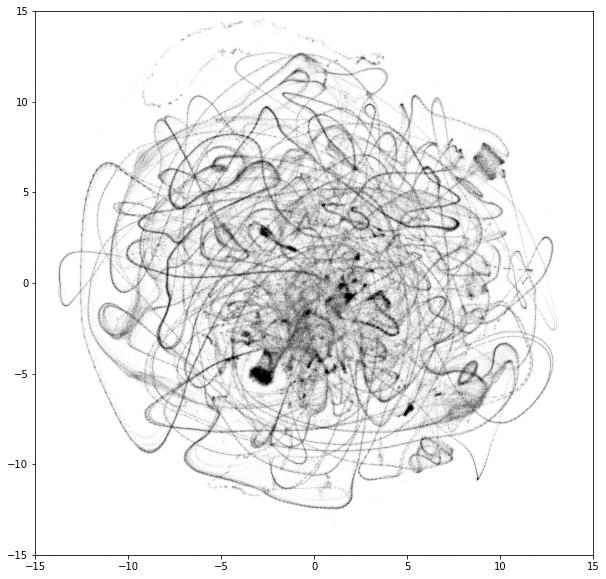

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [65]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig


In [63]:
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)

### create power-mask for sequences

In [17]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [18]:
power_masks = []
for li, spec in enumerate(specs):
    mask = np.expand_dims(norm(np.max(spec, axis=0))
        [24:-25],1)
    mask = (mask+1e-5)**.2
    power_masks.append(mask)

### plot seqs

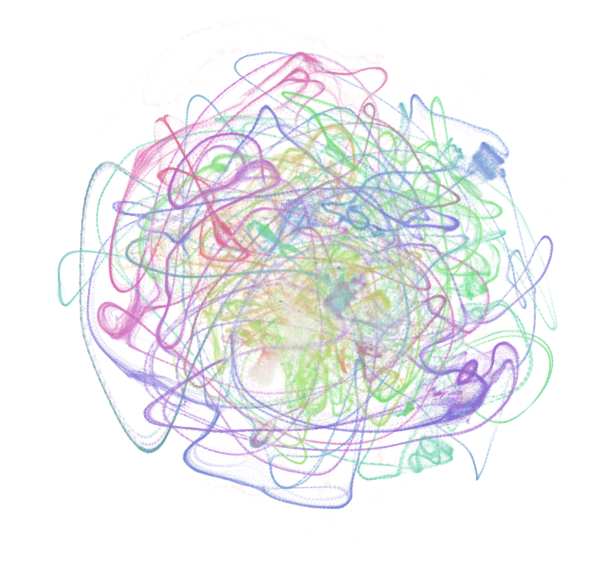

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
for wli, wl in tqdm(enumerate(window_lengths)):
    window_z = embedding[curr_idx:curr_idx + wl]
    cols = np.array(sns.color_palette('hls', len(window_z)))
    mask = power_masks[wli]
    cols = 1-((1-cols) * mask) #+ (add*(mask))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 0.05, s = 1, c= cols)
    curr_idx += wl
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.axis('off')

save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs_single_'+key), save_png=True)

In [20]:
cols = sns.color_palette('hsv', len(window_lengths))
len(cols)

56

(-15, 15)

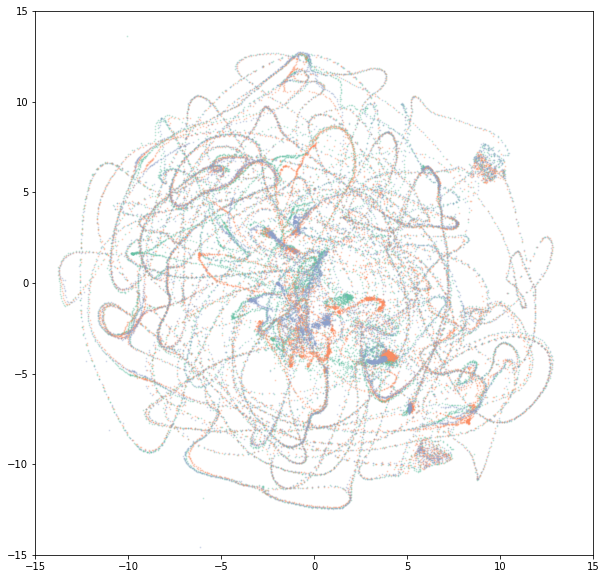

In [21]:
cols = sns.color_palette('Set2', 10)
fig, ax = plt.subplots(figsize=(10,10))
curr_idx = 0
for wli, wl in tqdm(enumerate(window_lengths[:3])):
    window_z = embedding[curr_idx:curr_idx + wl]    
    ax.scatter(window_z[:,0], window_z[:,1], alpha = .25, s = 1, color = cols[wli])
    curr_idx += wl
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

### regularity in song

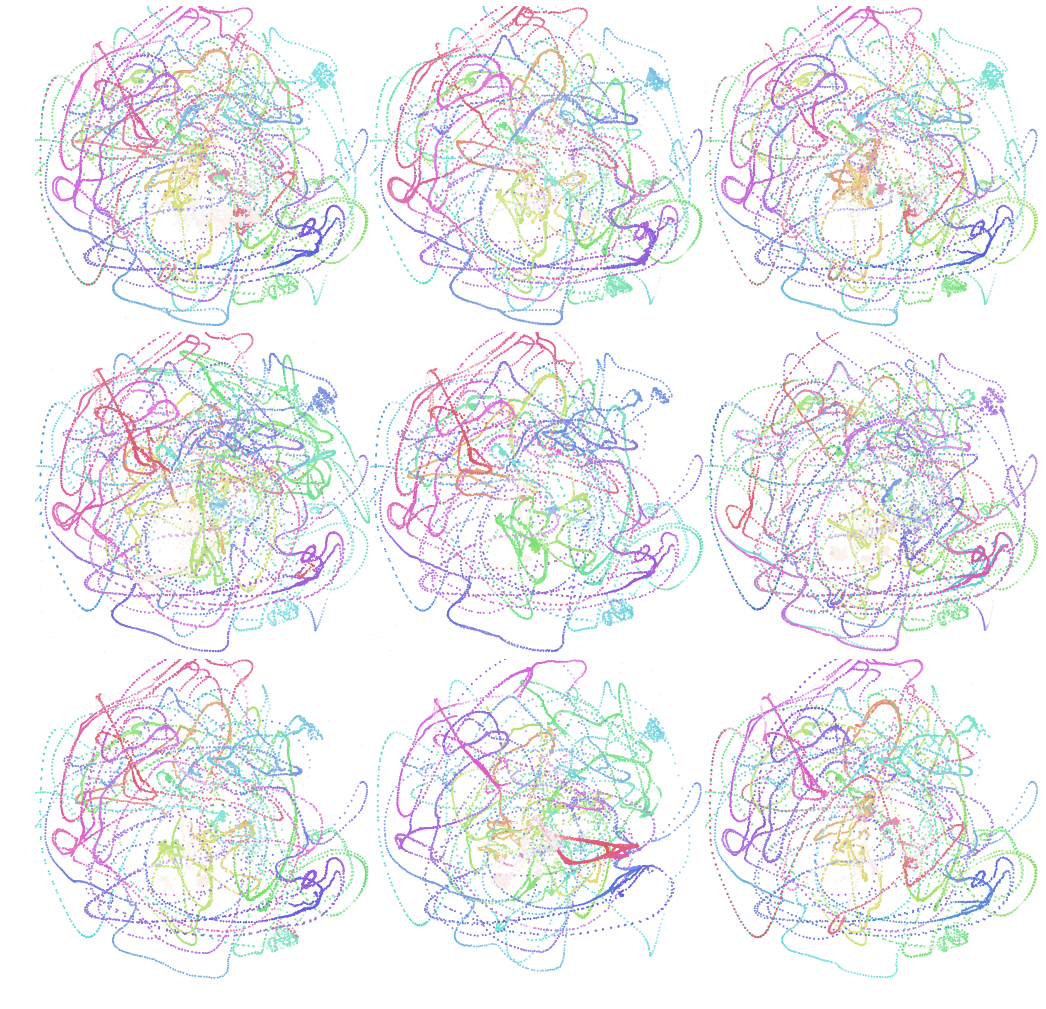

In [74]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(6*3,6*3), gridspec_kw = {'wspace':0, 'hspace':0})
curr_idx = 0
for wli, wl in tqdm(enumerate(window_lengths[:9])):
    window_z = embedding[curr_idx:curr_idx + wl]    
    ax = axs.flatten()[wli]
    cols = np.array(sns.color_palette('hls', len(window_z)))
    mask = power_masks[wli]
    cols = 1-((1-cols) * mask) #+ (add*(mask))
    ax.scatter(window_z[:,0], window_z[:,1], alpha = 1, s = 1, c = cols)
    ax.set_xlim([-13,13])
    ax.set_ylim([-13,12])
    ax.axis('off')
    
    curr_idx += wl

save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('umap_seqs'+key), save_png=True)

### plot specs with colorspace

In [99]:
import copy

z_normed = copy.deepcopy(embedding)
z_normed[z_normed > 10] = 10
z_normed[z_normed < -10] = -10
z_normed[:,0] = norm(z_normed[:,0])
z_normed[:,1] = norm(z_normed[:,1])

In [102]:
curr_idx = 0
rgb_imgs = []
for wli, wl in tqdm(enumerate(window_lengths)):
    window_z = z_normed[curr_idx:curr_idx + wl]    
    R = norm(window_z[:,0])
    G = norm(window_z[:,1])
    B = np.ones_like(G)*.5
    RGB = np.dstack((R,G,B))
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)
    curr_idx += wl

In [103]:
img_lens = [np.shape(i)[1] for i in rgb_imgs]
img_lens[:3]

[14144, 13623, 12613]

In [104]:
np.min(img_lens)

11262

In [105]:
rate = 44100

In [106]:
from matplotlib import gridspec
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

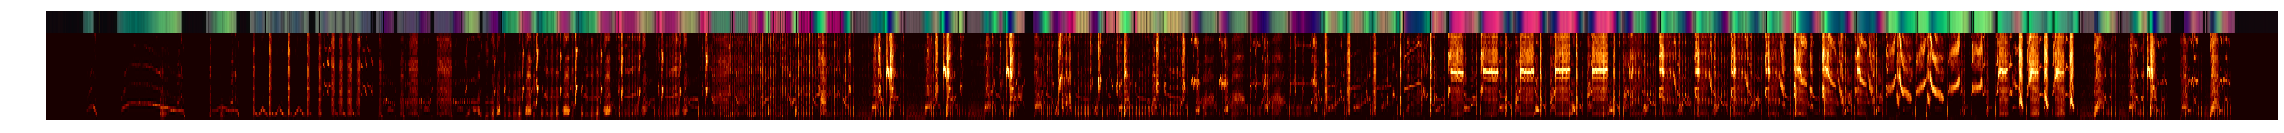

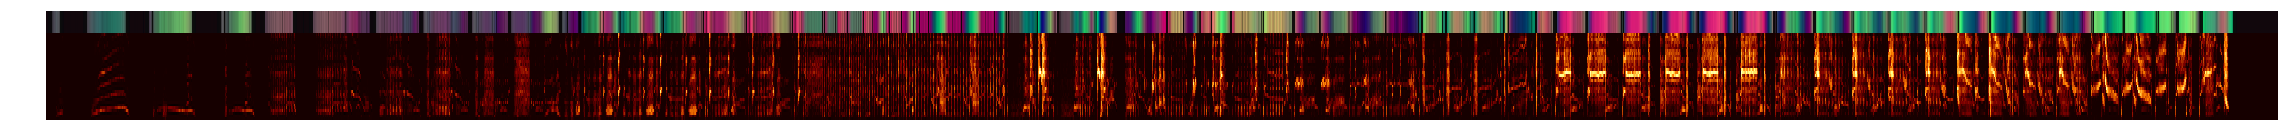

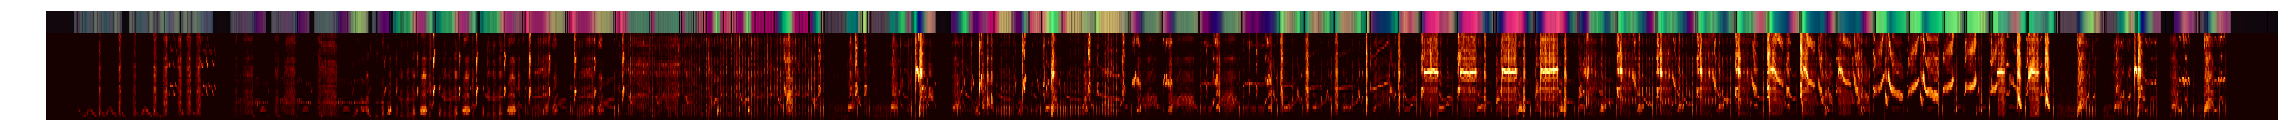

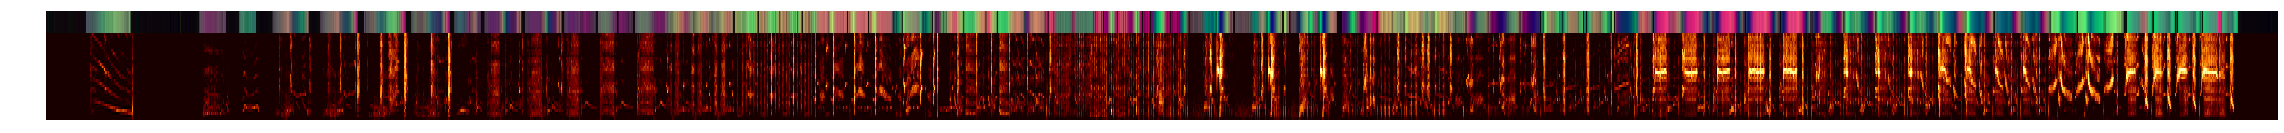

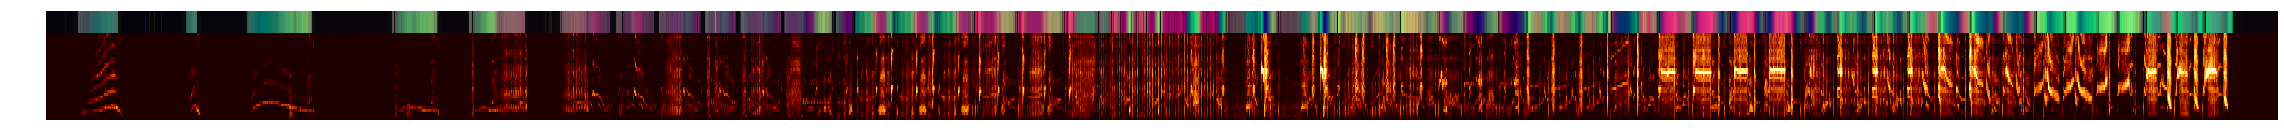

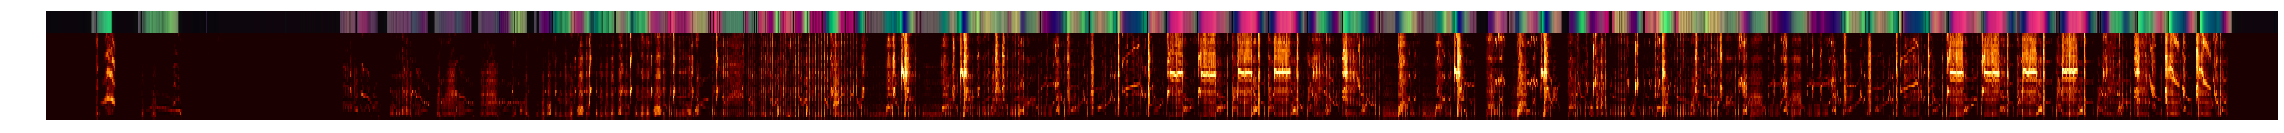

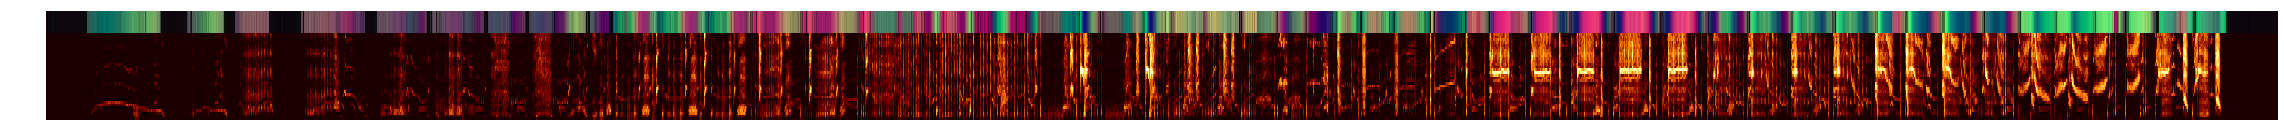

In [116]:
for i, (rgb_img, spec, key) in enumerate(zip(rgb_imgs, specs, keys)):
    fig = plt.figure(figsize=(40,2)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], wspace=0, hspace=0) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    mask = power_masks[i]
    rgb_img = ((rgb_img) * mask)
    ax0.imshow(rgb_img, interpolation=None, aspect='auto')
    plot_spec(spec, fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
    ax0.axis('off')
    ax1.axis('off')
    ax0.set_axis_off()
    ax1.set_axis_off()

    save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('spec_'+key), save_png=True)
    
    if i > 5:
        break

### cluster RGB images

In [108]:
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


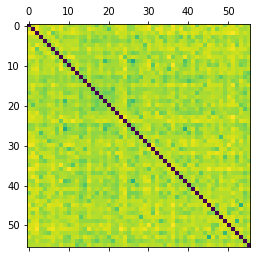

In [113]:
rgb_imgs_short = np.vstack([(np.squeeze(i)[int(np.min(img_lens)*.25):np.min(img_lens)]).flatten() for i in rgb_imgs])
dists = distance_matrix(rgb_imgs_short, rgb_imgs_short)
# hierarchical clustering
linkage_matrix = linkage(dists, "single")
plt.matshow(dists)

In [114]:
dn = dendrogram(
    linkage_matrix,
    p=6,
    truncate_mode="none",
    get_leaves=True,
    orientation="left",
    no_labels=True,
    link_color_func=lambda k: "k",
    show_contracted=False,
    no_plot=True
)

(56, 17632, 3)


(-0.5, 17631.5, 55.5, -0.5)

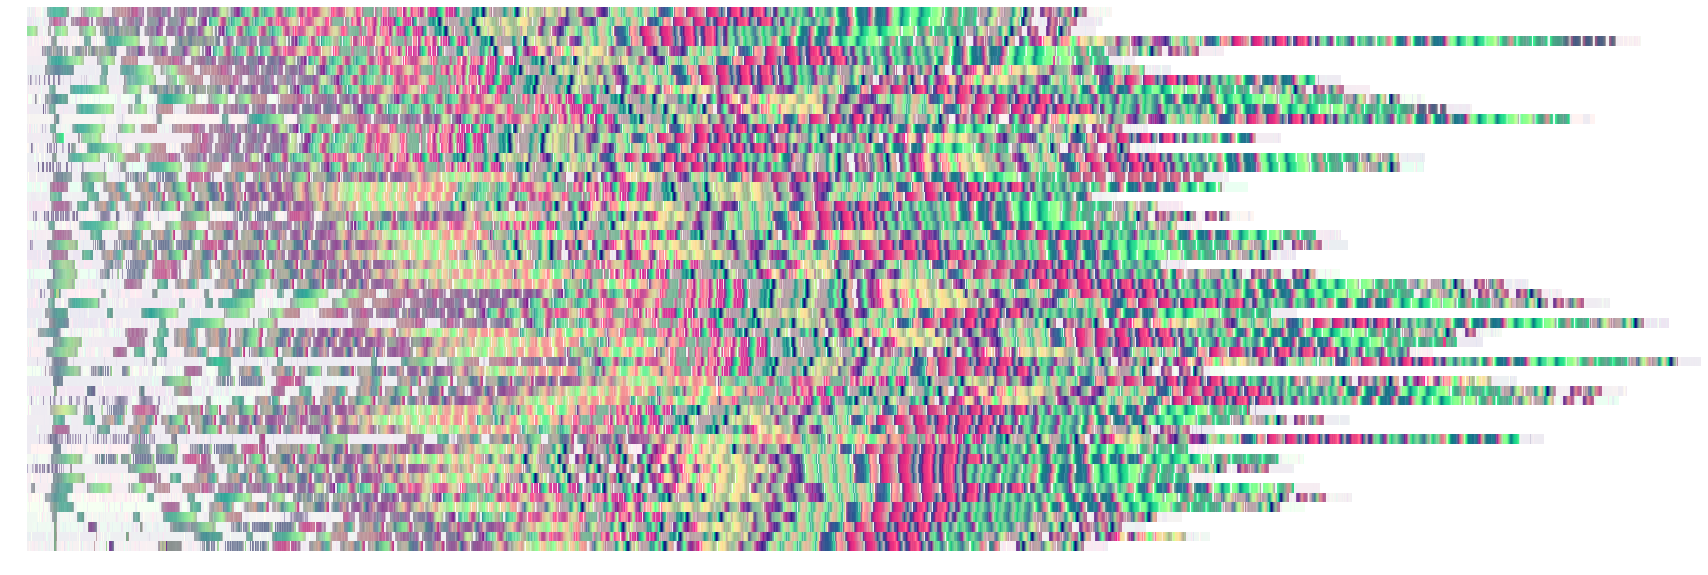

In [115]:
plot_mat = np.ones((len(img_lens), np.max(img_lens), 3))
print(np.shape(plot_mat))
for li, leaf in enumerate(dn['leaves']):
    mask = power_masks[leaf]
    seq = 1-((1-np.squeeze(rgb_imgs[leaf])) * mask)
    plot_mat[li, :len(seq), :] = seq

fig, ax = plt.subplots(figsize=(30,10))
ax.imshow(plot_mat, interpolation=None, aspect='auto')
ax.axis('off')
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / 'barcodes', save_png=True)